In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Aufgabe 1 Gradientenverfahren

<p style="border-left:5px solid red;padding:0.6em;box-sizing:border-box;">
<strong>Lernziele:</strong><br/>
    In der letzten Übung haben Sie lineare Regression kennen gelernt, mit der man Daten fitten kann, deren Parameter linear in die Funktion eingehen. Dieses Kriterium ist allerdings oft nicht erfüllt (z.B. bei Exponentialzerfällen, Gaussverteilungen, Lorentz-Funktionen etc.), was dazu führt, dass man numerische Methoden anwenden muss. Wir werden in dieser Übung das Gradientenverfahren anschauen. Die zugrundeliegende Idee ist, dass man die Summe der Residuenquadrate minimiert, indem man deren steilsten Gradienten bezüglich der Fitparameter folgt. </p>

<p style="border-left:5px solid blue;padding:0.6em;box-sizing:border-box;">
<strong>Wichtigste neuen Funktionen für diese Übung:</strong><br/>
    Dies sind die wichtigsten Funktionen die sie während dieser Übung benötigen:<br>
    Die jeweilige Syntax beschreibt eine examplarische Verwendung. Der Funktionsname ist jeweils ein Link zur offiziellen Dokumentation, welche alle Argumente der Funktion darlegt und ihre Funktionalität beschreibt. <br>
    <b>Funktionen zur statistischen Analyse: </b><br>
    <a href="https://numpy.org/doc/stable/reference/generated/numpy.linalg.inv.html">numpy.linalg.inv(...)</a><br>
    <a href="https://numpy.org/doc/stable/reference/generated/numpy.linalg.norm.html">numpy.linalg.norm(...)</a><br>
    <a href="https://numpy.org/doc/stable/reference/generated/numpy.diag.html">numpy.diag(...)</a><br>
    <a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html">scipy.optimize.curve_fit(...)</a><br>
    <b>Funktionen zum Plotten: </b><br>
    <a href="https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.errorbar.html"> axis.errorbar(...)</a> <br>
    <a href="https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.pcolormesh..html"> axis.pcolormesh(...)</a> <br>
</p>

## a)

Laden Sie zuerst die Daten aus dem File 'decay.txt'. Sie enthalten eine Spannung, die exponentiell mit der Zeit zerfällt,

$$ V(t) = Ae^{-\frac{t}{\tau}},$$

sowie deren Unsicherheiten. Stellen Sie die Werte mit Fehlerbalken dar, und schätzen Sie die Amplitude $A$ und die Zerfallszeit $\tau$  ab, indem Sie sie aus der Grafik lesen.

In [2]:
data1 = np.loadtxt('decay.txt', comments='#', delimiter=' ')
t = data1[0]
A = data1[1]
A_sigma = data1[2]

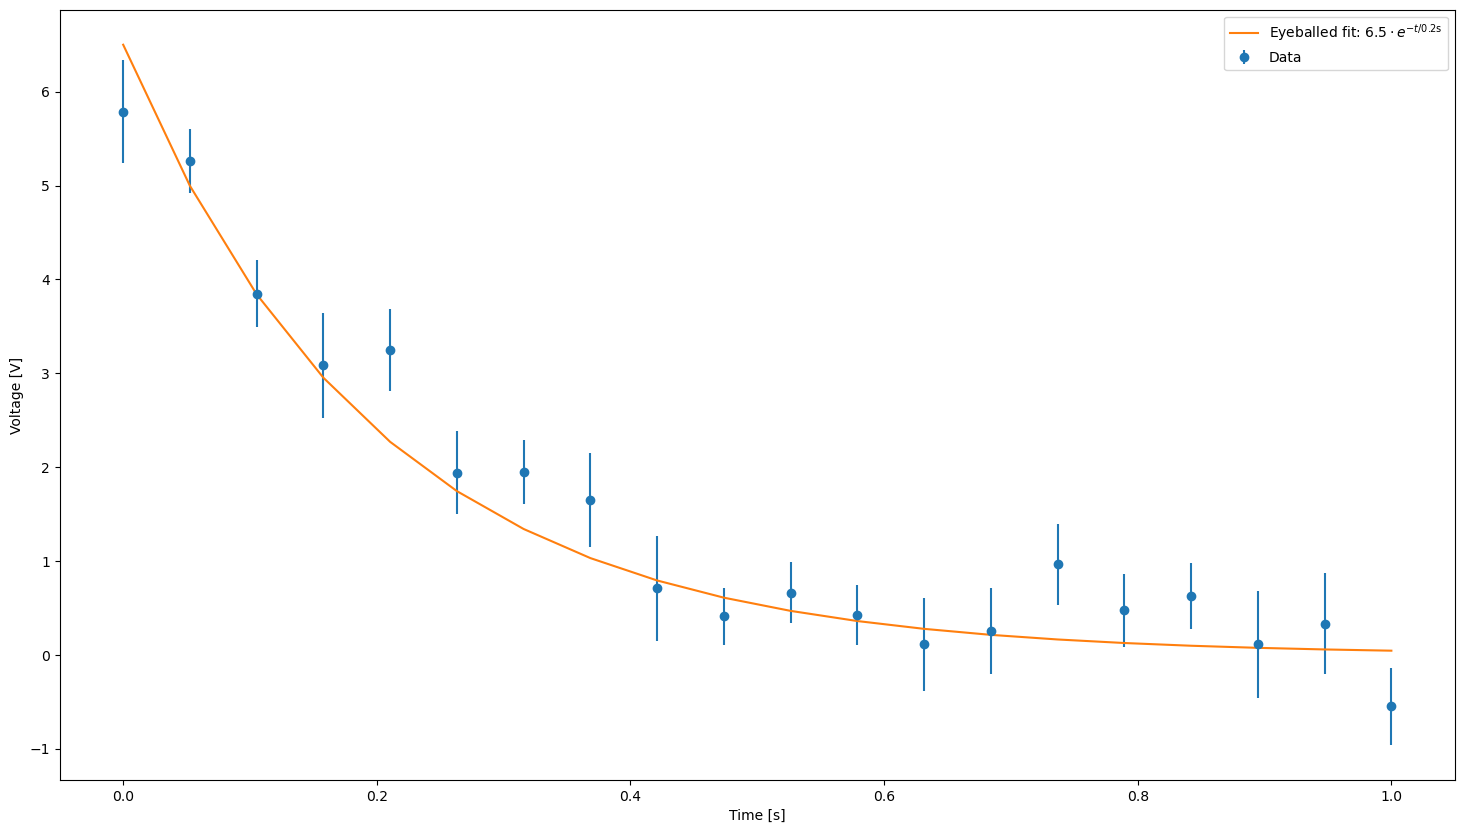

In [52]:
_, ax = plt.subplots(figsize=(18,10))
ax.set_xlabel('Time [s]')
ax.set_ylabel('Voltage [V]')
ax.errorbar(t, A, A_sigma, fmt='o', label='Data')
ax.plot(t, 6.5*np.exp(-t/0.2), label='Eyeballed fit: $6.5 \cdot e^{-t/0.2\mathrm{s}}$')
ax.legend()

## b)

Schreiben Sie zuerst eine Funktion $f(x,\vec{a})$, die das Modell beschreibt.

Anschliessend definieren Sie die Funktion die

$$S = \sum_{n=0}^{m} \frac{(y_i - f(x_i, \vec{a}))^2}{\sigma_i^2}$$

berechnet. Sie sollte $x$, $y$, $\sigma$, $f$ und $\vec{a}$ als Argumente nehmen und $S$ zurückgeben. Benutzen Sie die Funktion um $S$ für verschiedene Parameter $\vec{a}$ um die Werte herum zu berechnen, die Sie in a) abgeschätzt haben (je ca. 50 Punkte sollten genügen). Plotten Sie $\log(S)$ in einer 2D Grafik (Analog zur Übung 10). 


In [30]:
def model(x, a):
    return a[0] * np.exp(-x / a[1])

def Sres(x, y, sigma_y, f, a):
    return np.sum((y-f(x, a))**2 / sigma_y**2)

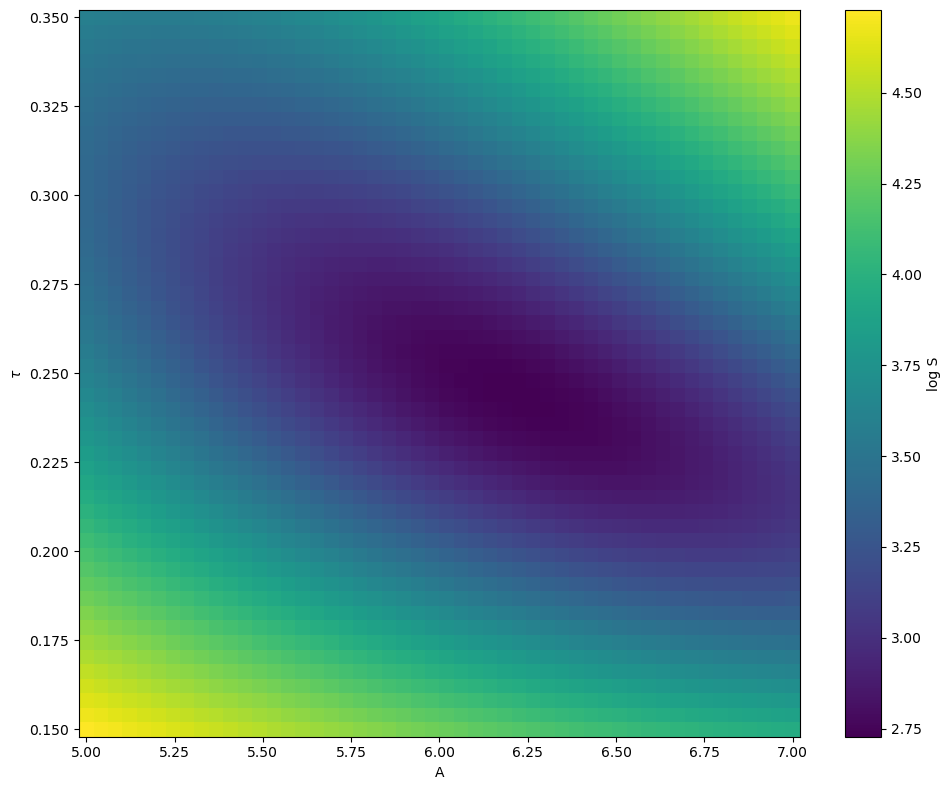

In [31]:
a0_val = np.linspace(5, 7, 50)
a1_val = np.linspace(0.15, 0.35, 50)
S_val = np.zeros(shape=(len(a0_val), len(a1_val)))

for i, a0_t in enumerate(a0_val):
    for j, a1_t in enumerate(a1_val):
        S_val[i, j] = np.log(Sres(t, A, A_sigma, model, (a0_t, a1_t)))
        
# 2D-Plot generieren
fig, ax = plt.subplots(figsize=(10,8))

# Beachten Sie, dass das Z-Array transponiert werden muss (.T), weil die
# pcolormesh erwartet, dass die erste Achse (äusseres Array) den vertikalen
# Pixeln (y-Achse) enspricht und die zweite Achse (inneres Array) den horizontalen.
im = ax.pcolormesh(a0_val, a1_val, S_val.T, shading='nearest')

# Colorbar für die Farbskala, mit Achsenbeschriftung
fig.colorbar(im, label='log S')

ax.set_xlabel('A')
ax.set_ylabel(r'$\tau$')

fig.tight_layout()

## c)

Für das Gradientenverfahren benötigen wir die erste und die zweite Ableitung von $S$ bezüglich der Parameter $a_i$. Man kann die erste Ableitung berrechnen indem man die Werte von $\vec{a}$ um einen kleinen Wert $\Delta$ variiert und die Differenz betrachtet. Um die Ableitung nach jedem Parameter separat zu berechnen, definieren wir den Vektor $\vec{\Delta}_i = \Delta \vec{e}_i$ der den Parameter $a_i$ variiert. Damit ergibt sich für die erste Ableitung:

$$
(\vec{\nabla}S)_i = \frac{\partial S}{\partial {a_i}} = \frac{S(x, y, \sigma, f, \vec{a} + \vec{\Delta}_i) - S(x, y, \sigma, f, \vec{a} - \vec{\Delta}_i)}{2\Delta}.
$$

Und die zweite:

$$
(\nabla^\top\nabla S)_{i,j} = \frac{\partial^2 S}{\partial a_i \partial a_j}= \frac{S(x, y, \sigma, f, \vec{a} + \vec{\Delta}_i + \vec{\Delta}_j) - S(x, y, \sigma, f, \vec{a}  - \vec{\Delta}_i + \vec{\Delta}_j) - S(x, y, \sigma, f, \vec{a}  + \vec{\Delta}_i - \vec{\Delta}_j) + S(x, y, \sigma, f, \vec{a}  - \vec{\Delta}_i - \vec{\Delta}_j)}{4\Delta^2}.
$$

Wir stellen eine Funktion für die zweite Ableitung zur Verfügung. Versuchen Sie die Schritte nachzuvollziehen und schreiben Sie analog dazu eine Funktion, die die erste Ableitung berechnet.

In [33]:
def dS2(x, y, sigma, f, a, delta):
    # Leere Matrix um die Komponenten zu speichern
    delta_S2 = np.zeros((len(a), len(a)))
    
    # Da wir über alle Kombinationen der a_i's ableiten müssen, iterieren wir in zwei verschachtelten Schlaufen über die
    # Einträge von a. 
    for i in range(len(a)):
        for j in range(len(a)):
            # Wir definieren neue Delta-Vektoren, die nur einen Eintrag in der Entsprechenden Dimension haben z.B. (Delta, 0)
            delta_i = np.zeros(len(a))
            delta_j = np.zeros(len(a))
            delta_i[i] = delta
            delta_j[j] = delta
            
            # Und wir berechnen die Matrixelemente so wie in der Aufgabenstellung gegeben.
            delta_S2[i,j] = (  Sres(x, y, sigma, f, a + delta_i + delta_j)
                             - Sres(x, y, sigma, f, a - delta_i + delta_j)
                             - Sres(x, y, sigma, f, a + delta_i - delta_j)
                             + Sres(x, y, sigma, f, a - delta_i - delta_j)) / (4 * delta * delta)
    
    return delta_S2

In [34]:
def dS(x, y, sigma, f, a, delta):
    nabla_S = np.zeros(len(a))
    
    for i in range(len(a)):
        delta_i = np.zeros(len(a))
        delta_i[i] = delta
        nabla_S[i] = (Sres(x, y, sigma, f, a + delta_i) - Sres(x, y, sigma, f, a - delta_i)) / (2 * delta)
    
    return nabla_S

## d)

Schreiben Sie nun eine Funktion, die das Gradientenverfahren anwendet, um die optimalen Parameter zu finden. Berechnen Sie dazu zuerst $\vec{\nabla} S$ und dessen Betrag $|dS| = |\vec{\nabla} S|$ für einen Startwert $\vec{a}_0$. Berechnen Sie anschliessend den nächsten Wert $\vec{a} = \vec{a}_0-\alpha\vec{\nabla} S $ mithilfe des Proportionalitätswertes $\alpha$ und dann vom neuen $\vec{a}$ wieder $\vec{\nabla} S$ und $|dS|$. Iterieren Sie nun über diesen Prozess mit einem `while` loop, bis $|dS|$ klein genug ist. Als Alternative sollten Sie auch eine maximale Anzahl Iterationen $i_{\mathrm{max}}$ als Abbruchbedingung definieren, falls die Annäherung zum Minimum zu langsam oder gar nicht konvergiert. Es ist sinnvoll, in einer Fitfunktion auch direkt die Kovarianzmatrix zu berechnen, dazu können Sie die Funktion `np.linalg.inv` benutzen.

Die Funktion sollte also folgende Argument nehmen: $x$, $y$, $\sigma$, $f$, $\vec{a}_0$, $\Delta$, $\alpha$, $|dS|_{min}$ und $i_{max}$. Die Funktion sollte die optimalen Parameter sowie die Kovarianzmatrix als Resultate zurückgeben. Zudem sollte sie auch noch $|dS|$ für jede Iteration speichern und zusammen mit der Anzahl ausgeführten Iterationen zurückgeben.

In [48]:
def my_gradient(x, y, sigma, f, a0, delta, alpha, dS_min, i_max):
    dSs = np.zeros((i_max+1, len(a0)))
    dSs[0] = dS(x, y, sigma, f, a0, delta)
    dS_abs = np.zeros(i_max+1)
    dS_abs[0] = np.linalg.norm(dSs[0])
    a = a0
    i = 0
    while i < i_max and dS_abs[i] >= dS_min:
        a = a - alpha * dSs[i]
        dSs[i+1] = dS(x, y, sigma, f, a, delta)
        dS_abs[i+1] = np.linalg.norm(dSs[i+1])
        i += 1
    
    return a, i, np.trim_zeros(dS_abs), 2*np.linalg.inv(dS2(x, y, sigma, f, a, delta))

## e)

Fitten Sie nun die Parameter mit dem Gradientenverfahren. Was sind die optimalen Parameter und ihre Fehler, wie viele Iterationen hat der Algorithmus gebraucht?

Benutzen Sie als Anfangswerte Ihre Abschätzungen von Aufgabe a). Für die restlichen Parameter können Sie die folgenden Werte verwenden, schauen Sie sich aber auch mal an, was passiert, wenn Sie diese variieren.

$$
\Delta = 10^{-4}\qquad\alpha = 10^{-5}\qquad{}|dS|_{min} = 10^{-3}\qquad{}i_{max} = 10^{5}
$$

In [51]:
print(my_gradient(t, A, A_sigma, model, (6, 0.25), 1E-4, 1E-5, 1E-3, 100000))

(array([6.21822046, 0.24364976]), 45760, array([2.02689248e+01, 1.85802224e+01, 1.70465380e+01, ...,
       1.00019748e-03, 1.00001694e-03, 9.99836508e-04]), array([[ 0.11065771, -0.00426326],
       [-0.00426326,  0.00037793]]))


## f)

Um die Plausibilität der Fitresultate zu überprüfen, plotten Sie nochmals die Daten mit Fehlerbalken und dazu die Exponentialfunktion mit den berechneten optimalen Parametern. Sie sollten sehen, dass die berechnete Funktion in den meisten Fällen innerhalb der Fehlerbalken liegt. Schauen Sie sich auch an, wie schnell der Fit besser wird, indem Sie $|dS|$ als Funktion des Iterations-Indexes darstellen.

Bonus: Modifizieren Sie Ihre Funktion des Gradientenverfahrens so, dass sie bei jeder Iteration den aktuellen Wert von $\vec{a}$ speichert und zurückgibt. Plotten Sie nun nochmals die 2D Map von Aufgabe b), Sie können nun mit `plt.plot` direkt die Werte von $\vec{a}$ darüber plotten. Damit können Sie direkt verfolgen, welchen Weg das Gradientenverfahren einschlägt.

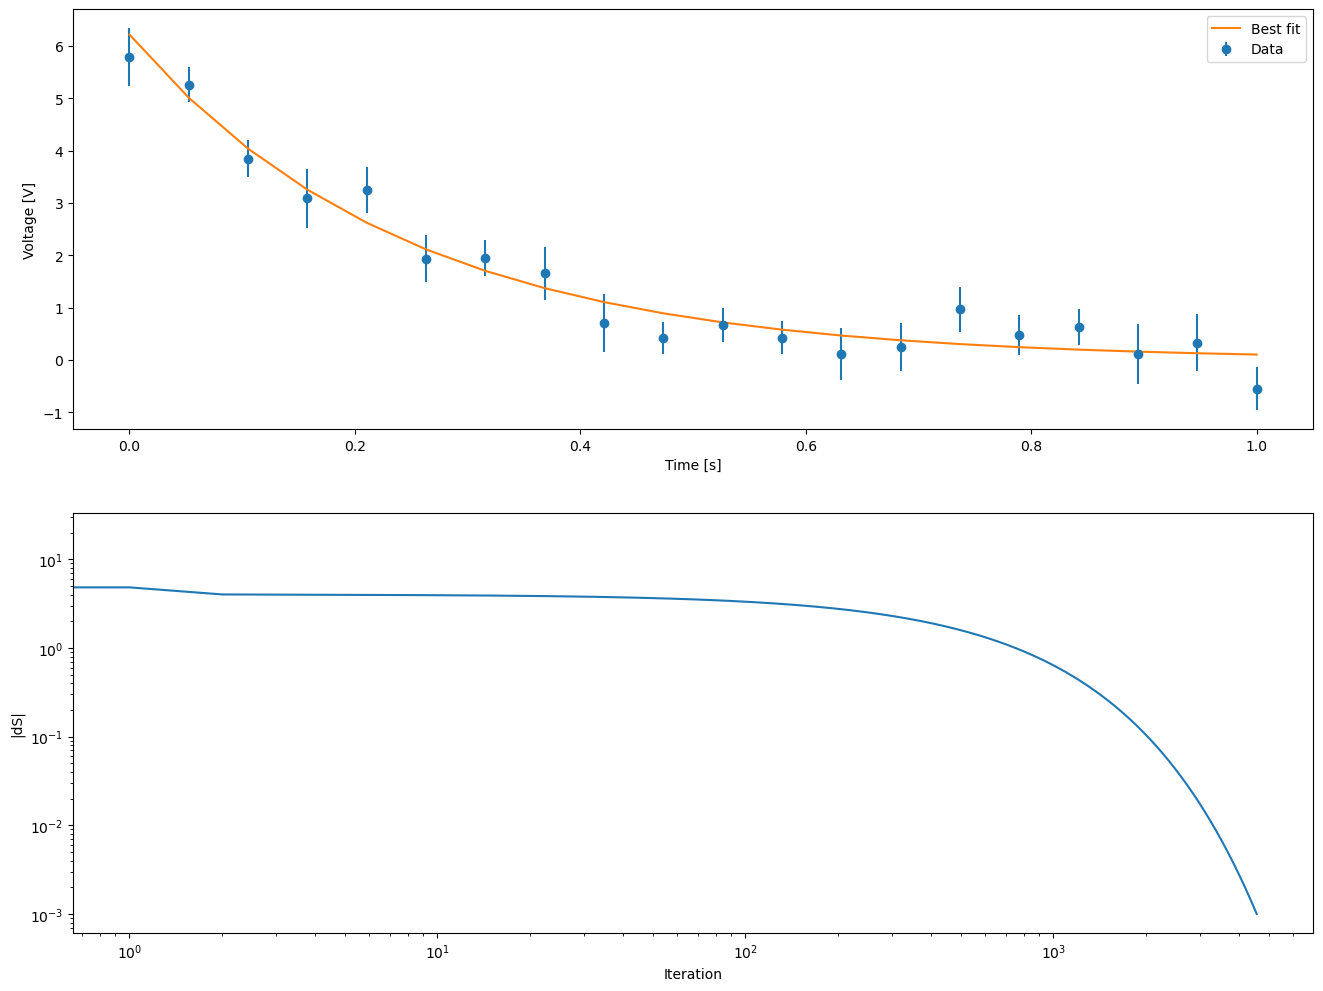

In [75]:
fit = my_gradient(t, A, A_sigma, model, (6, 0.25), 1E-4, 1E-4, 1E-3, 100000)
A0, tau = fit[0]
its = fit[1]
dS_abs = fit[2]

_, axs = plt.subplots(2, figsize=(16,12))
axs[0].set_xlabel('Time [s]')
axs[0].set_ylabel('Voltage [V]')
axs[0].errorbar(t, A, A_sigma, fmt='o', label='Data')
axs[0].plot(t, A0 * np.exp(-t/tau), label='Best fit')
axs[0].legend()
axs[1].set_xlabel('Iteration')
axs[1].set_ylabel('|dS|')
axs[1].loglog(range(its+1), dS_abs)

## g)

Das Verfahren lässt sich beschleunigen, indem man die Schrittgrösse $\alpha$ proportional zur Steigung von $dS$, also der zweiten Ableitung, skaliert. Die entsprechende Formel für die Parameter ist wie folgt:
$$
a_i = a_{i,0} - \alpha\left(\frac{\partial^2 S}{\partial a_i \partial a_i}\right)^{-1} \frac{\partial S}{\partial a_i}
$$

Schreiben Sie eine neue Funktion, die proportionale Schrittgrössen verwendet und fitten Sie erneut die Daten. Sie können die gleichen Parameter verwenden, mit Ausnahme von $\alpha=1$. Überprüfen Sie erneut die Qualität des Fits, indem Sie die Funktion mit den optimalen Parametern zusammen mit den Daten plotten. Vergleichen Sie auch wie schnell $|dS|$ abnimmt im Vergleich zur obigen Funktion.

Bonus: Sie können sich auch hier wieder die Werte von $\vec{a}$ ausgeben lassen und in den 2D Plot einfügen.

In [62]:
def my_dynamic_gradient(x, y, sigma, f, a0, delta, alpha, dS_min, i_max):
    dSs = np.zeros((i_max+1, len(a0)))
    dSs[0] = dS(x, y, sigma, f, a0, delta)
    dS_abs = np.zeros(i_max+1)
    dS_abs[0] = np.linalg.norm(dSs[0])
    a = a0
    i = 0
    while i < i_max and dS_abs[i] >= dS_min:
        a = a - alpha * dSs[i] / np.diagonal(dS2(x, y, sigma, f, a, delta))
        dSs[i+1] = dS(x, y, sigma, f, a, delta)
        dS_abs[i+1] = np.linalg.norm(dSs[i+1])
        i += 1
    
    return a, i, np.trim_zeros(dS_abs), 2*np.linalg.inv(dS2(x, y, sigma, f, a, delta))

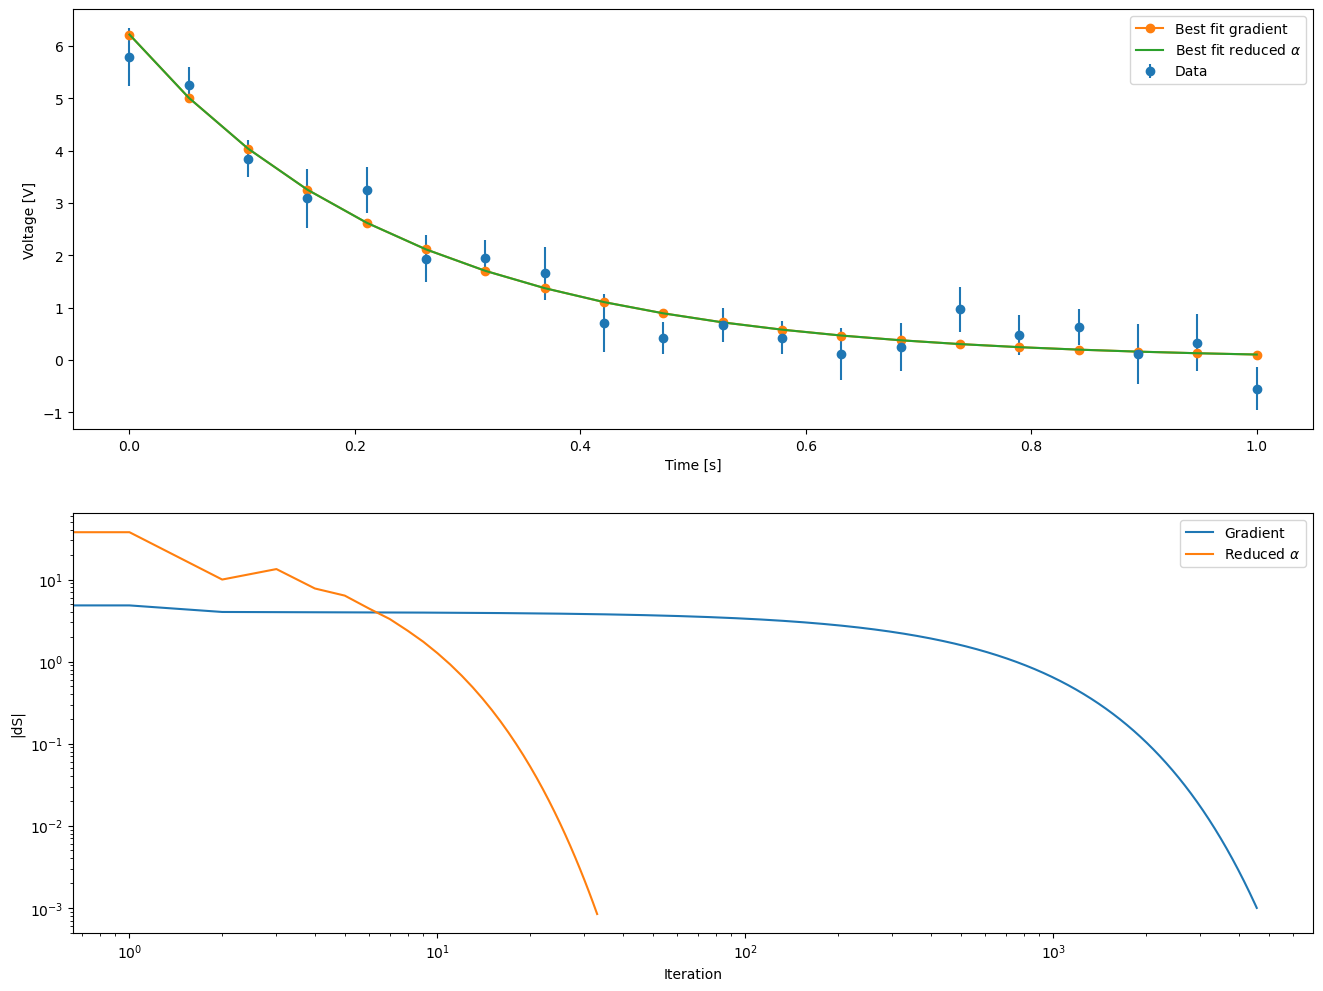

In [74]:
fit1 = my_gradient(t, A, A_sigma, model, (6, 0.25), 1E-4, 1E-4, 1E-3, 100000)
A01, tau1 = fit1[0]
its1 = fit1[1]
dS_abs1 = fit1[2]

fit = my_dynamic_gradient(t, A, A_sigma, model, (6, 0.25), 1E-4, .8, 1E-3, 100000)
A0, tau = fit[0]
its = fit[1]
dS_abs = fit[2]

_, axs = plt.subplots(2, figsize=(16,12))
axs[0].set_xlabel('Time [s]')
axs[0].set_ylabel('Voltage [V]')
axs[0].errorbar(t, A, A_sigma, fmt='o', label='Data')
axs[0].plot(t, A01 * np.exp(-t/tau1), 'o-', label='Best fit gradient')
axs[0].plot(t, A0 * np.exp(-t/tau), label=r'Best fit reduced $\alpha$')
axs[0].legend()
axs[1].set_xlabel('Iteration')
axs[1].set_ylabel('|dS|')
axs[1].loglog(range(its1+1), dS_abs1, label='Gradient')
axs[1].loglog(range(its+1), dS_abs, label=r'Reduced $\alpha$')
axs[1].legend()

## h)

In der Vorlesung haben sie `lmfit` gesehen, eine Alternative ist `curve_fit` von `scipy.optimize` zu benutzen. Der Unterschied ist lediglich das Interface, im Hintergrund machen beide Methoden dasselbe. Verwenden Sie `curve_fit` um die Daten zu fitten und vergleichen Sie die Werte.

Falls Sie die Parameter zuvor als Vektoren an die Exponentialfunktion übergeben haben, ist es hier einfacher wenn Sie die Parameter einzeln übergeben. Sprich:

$$
f(x, \vec{a}) \qquad \Rightarrow \qquad f(x, a_1, a_2,...)
$$

In [77]:
from scipy.optimize import curve_fit

def model2(x, A, tau):
    return A * np.exp(-x / tau)

print(curve_fit(model2, t, A, (6, 0.25), A_sigma))

(array([6.21827575, 0.24364763]), array([[ 0.09559107, -0.00375934],
       [-0.00375934,  0.00033325]]))
